<a href="https://colab.research.google.com/github/nitingarg2015/EVA8/blob/master/Assignment%209/Assignment_9_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required libraries/ packages

In [1]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline
from torch.utils.data import DataLoader
import math


In [2]:
#install torchsummary and torch-lr-finder if required

try:
    from torchsummary import summary
except ImportError:
    !pip install torchsummary
    from torchsummary import summary

try:
    from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
except ImportError:
    !pip install torch-lr-finder
    from torch_lr_finder import LRFinder

# !pip install grad-cam

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone model, utility and other files from Git repository

In [3]:
!git clone  https://github.com/nitingarg2015/Refs.git

Cloning into 'Refs'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 110 (delta 58), reused 81 (delta 34), pack-reused 0
Receiving objects: 100% (110/110), 25.00 KiB | 25.00 MiB/s, done.
Resolving deltas: 100% (58/58), done.


## Import and load Ultimus model

In [4]:
from Refs.models import basic_attention

model = basic_attention.AttnNet(in_nodes = 48, d_k = 8, dropout=0.1, no_classes=10)
model

AttentionNet(
  (conv): ConvNet(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
    )
    (GAP): Sequential(
      (0): AvgPool2d(kernel_size=4, stride=4, padding=0)
    )
  )
  (ultimus1): Ultimus(
    (query): Linear(in_features=48, out_features=8, bias=True)
    (keys): Linear(in_features=48, out_features=8, bias=True)
    (value

In [5]:
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
       BatchNorm2d-2           [-1, 16, 16, 16]              32
           Dropout-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           4,640
       BatchNorm2d-5             [-1, 32, 8, 8]              64
           Dropout-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 48, 4, 4]          13,872
       BatchNorm2d-8             [-1, 48, 4, 4]              96
           Dropout-9             [-1, 48, 4, 4]               0
        AvgPool2d-10             [-1, 48, 1, 1]               0
          ConvNet-11                   [-1, 48]               0
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

## Load CIFAR train and test data loaders

In [6]:
#import load_CIFAR_dataloader

from Refs.utils import CIFARdata 

#set batch size
batch_size = 512

#load training dataset
classes, train_loader = CIFARdata.load_CIFAR_dataloader(train = True, transform = True, batch_size = batch_size)
#load test dataset
_, test_loader = CIFARdata.load_CIFAR_dataloader(train = False, transform = False, batch_size = batch_size)

len(train_loader), len(test_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(98, 20)

## View sample images

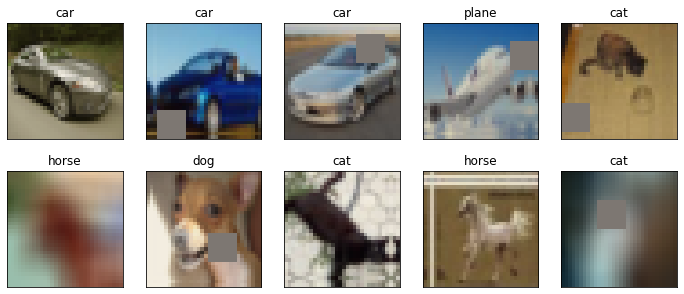

In [7]:
# get some random training images
from Refs.utils import utils

import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

no_images = 10

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 5, index)
    utils.imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = str(classes[labels[index - 1]])
    plt.title(title)


## Train model for 24 Epochs with CIFAR train data loader

In [10]:
from Refs import main_ass8
model = basic_attention.AttnNet(in_nodes = 48, d_k = 8, dropout=0, no_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.001,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, train_losses, train_acc_all, test_losses, test_acc_all = main_ass8.fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=train_loader, 
                                                    testloader=test_loader,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler  
                                                )

EPOCH: 1 (LR: 0.0001)


100%|██████████| 98/98 [00:09<00:00, 10.12it/s]



Average Training Loss=0.004513149185180664, Accuracy=10.0
Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 2 (LR: 0.0003507106310403638)


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]



Average Training Loss=0.00451313223361969, Accuracy=10.0
Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 3 (LR: 0.0006014212620807277)


100%|██████████| 98/98 [00:09<00:00, 10.22it/s]



Average Training Loss=0.0045057374477386475, Accuracy=13.242
Test set: Average loss: 0.0046, Accuracy: 1674/10000 (16.74%)

EPOCH: 4 (LR: 0.0008521318931210915)


100%|██████████| 98/98 [00:09<00:00, 10.22it/s]



Average Training Loss=0.004402688765525818, Accuracy=18.458
Test set: Average loss: 0.0045, Accuracy: 1900/10000 (19.00%)

EPOCH: 5 (LR: 0.0009798921578631453)


100%|██████████| 98/98 [00:09<00:00, 10.10it/s]



Average Training Loss=0.004365225620269775, Accuracy=18.84
Test set: Average loss: 0.0044, Accuracy: 1924/10000 (19.24%)

EPOCH: 6 (LR: 0.0009308730402160865)


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]



Average Training Loss=0.004339631428718567, Accuracy=21.304
Test set: Average loss: 0.0044, Accuracy: 2341/10000 (23.41%)

EPOCH: 7 (LR: 0.0008818539225690276)


100%|██████████| 98/98 [00:09<00:00, 10.23it/s]



Average Training Loss=0.0043180733251571655, Accuracy=23.162
Test set: Average loss: 0.0044, Accuracy: 2403/10000 (24.03%)

EPOCH: 8 (LR: 0.0008328348049219688)


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]



Average Training Loss=0.004307409782409668, Accuracy=23.62
Test set: Average loss: 0.0044, Accuracy: 2455/10000 (24.55%)

EPOCH: 9 (LR: 0.0007838156872749099)


100%|██████████| 98/98 [00:09<00:00, 10.03it/s]



Average Training Loss=0.004298781142234802, Accuracy=23.994
Test set: Average loss: 0.0044, Accuracy: 2439/10000 (24.39%)

EPOCH: 10 (LR: 0.0007347965696278511)


100%|██████████| 98/98 [00:09<00:00, 10.09it/s]



Average Training Loss=0.004293371601104736, Accuracy=24.194
Test set: Average loss: 0.0044, Accuracy: 2529/10000 (25.29%)

EPOCH: 11 (LR: 0.0006857774519807922)


100%|██████████| 98/98 [00:09<00:00,  9.97it/s]



Average Training Loss=0.004289733939170837, Accuracy=24.41
Test set: Average loss: 0.0044, Accuracy: 2499/10000 (24.99%)

EPOCH: 12 (LR: 0.0006367583343337335)


100%|██████████| 98/98 [00:09<00:00, 10.13it/s]



Average Training Loss=0.004283499712944031, Accuracy=24.87
Test set: Average loss: 0.0044, Accuracy: 2544/10000 (25.44%)

EPOCH: 13 (LR: 0.0005877392166866747)


100%|██████████| 98/98 [00:09<00:00, 10.23it/s]



Average Training Loss=0.004283380365371704, Accuracy=24.954
Test set: Average loss: 0.0044, Accuracy: 2524/10000 (25.24%)

EPOCH: 14 (LR: 0.0005387200990396158)


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]



Average Training Loss=0.004278504252433777, Accuracy=25.474
Test set: Average loss: 0.0044, Accuracy: 2602/10000 (26.02%)

EPOCH: 15 (LR: 0.000489700981392557)


100%|██████████| 98/98 [00:09<00:00, 10.22it/s]



Average Training Loss=0.004272243375778198, Accuracy=26.268
Test set: Average loss: 0.0043, Accuracy: 2742/10000 (27.42%)

EPOCH: 16 (LR: 0.00044068186374549814)


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]



Average Training Loss=0.004265599913597107, Accuracy=27.118
Test set: Average loss: 0.0043, Accuracy: 2881/10000 (28.81%)

EPOCH: 17 (LR: 0.0003916627460984394)


100%|██████████| 98/98 [00:09<00:00, 10.21it/s]



Average Training Loss=0.004259399099349976, Accuracy=27.742
Test set: Average loss: 0.0043, Accuracy: 2952/10000 (29.52%)

EPOCH: 18 (LR: 0.00034264362845138046)


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]



Average Training Loss=0.004248260164260865, Accuracy=28.638
Test set: Average loss: 0.0043, Accuracy: 2965/10000 (29.65%)

EPOCH: 19 (LR: 0.0002936245108043217)


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]



Average Training Loss=0.004241198077201843, Accuracy=28.892
Test set: Average loss: 0.0043, Accuracy: 3050/10000 (30.50%)

EPOCH: 20 (LR: 0.0002446053931572629)


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]



Average Training Loss=0.004236304197311401, Accuracy=28.924
Test set: Average loss: 0.0043, Accuracy: 2971/10000 (29.71%)

EPOCH: 21 (LR: 0.00019558627551020404)


100%|██████████| 98/98 [00:09<00:00, 10.19it/s]



Average Training Loss=0.0042290030097961425, Accuracy=29.414
Test set: Average loss: 0.0043, Accuracy: 3083/10000 (30.83%)

EPOCH: 22 (LR: 0.0001465671578631452)


100%|██████████| 98/98 [00:09<00:00, 10.08it/s]



Average Training Loss=0.004227466506958008, Accuracy=29.408
Test set: Average loss: 0.0043, Accuracy: 3051/10000 (30.51%)

EPOCH: 23 (LR: 9.754804021608636e-05)


100%|██████████| 98/98 [00:09<00:00, 10.18it/s]



Average Training Loss=0.004223490085601807, Accuracy=29.698
Test set: Average loss: 0.0043, Accuracy: 3089/10000 (30.89%)

EPOCH: 24 (LR: 4.852892256902762e-05)


100%|██████████| 98/98 [00:09<00:00, 10.17it/s]



Average Training Loss=0.0042196294403076175, Accuracy=29.918
Test set: Average loss: 0.0043, Accuracy: 3093/10000 (30.93%)



## Plot training/ test Accuracy and Loss

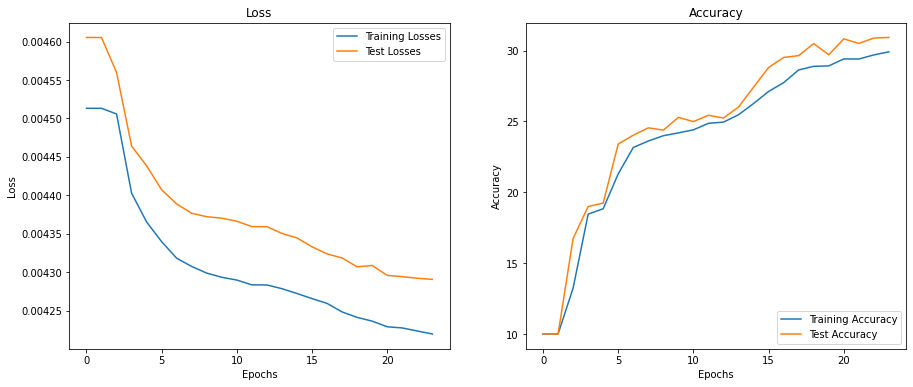

In [11]:
from Refs.utils import utils

utils.plot_LossAndAcc(train_acc_all, train_losses,test_acc_all,test_losses)

## Test Accuracy

In [12]:
from Refs import main_ass8

main_ass8.test(model, device, test_loader, criterion = nn.CrossEntropyLoss())

Test set: Average loss: 0.0043, Accuracy: 3093/10000 (30.93%)



(0.004290341019630432, 30.93)

## Retrieve data for misclassified images

In [13]:
from Refs.utils import utils

data_images, pred_labels, target_labels = utils.get_mis_classified_byloader(model, device, test_loader)
print(len(data_images), len(pred_labels), len(target_labels))

6907 6907 6907


## Plot mis classified images

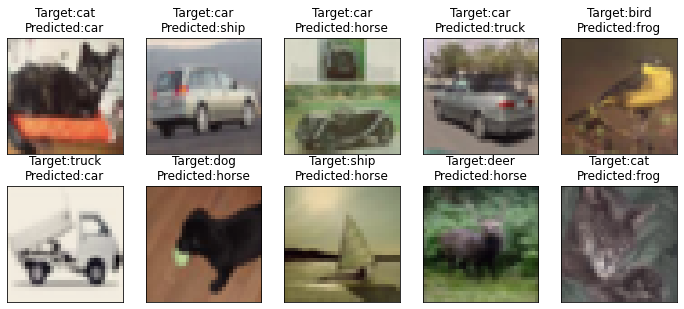

In [14]:
import matplotlib.pyplot as plt
from Refs.utils import utils
        
utils.plot_misclassified(data_images, target_labels, pred_labels, classes, no_images= 10)